In [2]:
%load_ext autoreload
%autoreload 2

In [38]:
import numpy as np
import pandas as pd
import xfoil as xf

import matplotlib.pyplot as plt

from model import generate_middle_points

plt.style.use('ggplot')

In [8]:
airfoil = xf.XFoil()

In [18]:
airfoil.repanel(n_nodes=10)

In [20]:
airfoil.naca('0012')

In [23]:
_x = airfoil.airfoil.x
_y = airfoil.airfoil.y

In [27]:
_x = _x[::10]
_y = _y[::10]

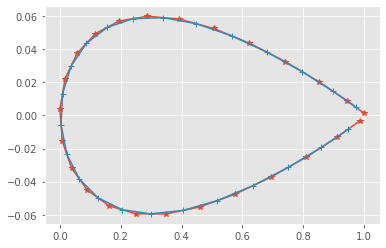

In [41]:
plt.plot(_x, _y, marker = '*')
plt.plot(generate_middle_points(_x), generate_middle_points(_y), marker = '+')

In [130]:
class Panel():
    """
    Panel discretization.
    
    self.start = np.array([x, y])
    """
    
    def __init__(self, start, end):
        """
        Parameters
        ----------
        start: np.array
            [x, y]
        
        end: np.array
            [x, y]
        """
        self.start = start
        self.end   = end
        
    @property
    def xs(self):
        """
        X coordinates.
    
        Returns
        -------
        np.array
            [start, end]
        """
        return np.array([self.start[0], self.end[0]])

    @property
    def ys(self):
        """
        Y coordinates.
    
        Returns
        -------
        np.array
            [start, end]
        """
        return np.array([self.start[1], self.end[1]])    

    @property
    def length(self):
        """
        Panel length.
        """
        _length = self.end - self.start
        _length = np.power(_length, 2.0)
        _length = np.sum(_length)
        _length = np.sqrt(_length)
        
        return _length
    
    def eta_point(self, eta = 0.5):
        """
        Coordinates eta units from the start.
        
        Parameters
        ----------
        eta: float
            Between 0 and 1.
            eta = 0: start
            eta = 1: end
            
        Returns
        -------
        np.array
            [x, y]
        """
        return (1.0 - eta) * self.start + eta * self.end
    
    @property
    def mid_point(self):
        """
        Mid-point coordinates. 
        """
        return self.eta_point(eta = 0.5)
    
    @property
    def mid_point_x(self):
        """
        Mid-point X coordinate. 
        """
        return self.mid_point[0]
    
    @property
    def mid_point_y(self):
        """
        Mid-point Y coordinate. 
        """
        return self.mid_point[1]
    
    @property
    def angle(self):
        """
        Panel angle in radians. 
        
        Returns
        -------
        float 
        """
        x_start, x_end = self.xs
        y_start, y_end = self.ys
        
        NUM = y_end - y_start
        DEN = x_end - x_start
        
        angle = np.arctan2(NUM, DEN)
        
        return angle
    
    def plot(self):
                
        xs = self.xs
        ys = self.ys
            
        plt.plot(xs, ys)
        
        plt.text(xs[0], ys[0], 'Start')
        plt.text(xs[1], ys[1], 'End')

In [131]:
def distance(x1, x2):
    """
    Compute distance between two points.
    """
    x1 = np.array(x1)
    x2 = np.array(x2)
    
    length = x2 - x1
    length = np.power(length, 2.0)
    length = np.sum(length)
    length = np.sqrt(length)
    
    return length

In [114]:
panels = []

for x_start, x_end, y_start, y_end in zip(_x, _x[1:], _y, _y[1:]):
    
    start = np.array([x_start, y_start])
    end   = np.array([x_end,   y_end])
    
    panel = Panel(start=start, end=end)
    
    panels.append(panel)

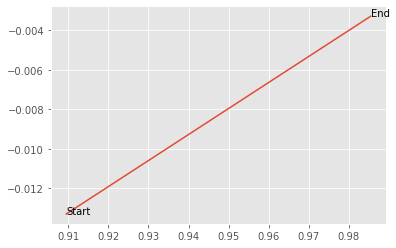

In [115]:
panel.plot()

In [116]:
panel.mid_point

array([ 0.94747895, -0.00828501])

In [117]:
panel.eta_point(eta = 0.1)

array([ 0.91710209, -0.01228638])

In [118]:
num_panels = len(panels)

In [119]:
# Matrices initialization
Cn1 = np.zeros((num_panels, num_panels))
Cn2 = np.zeros((num_panels, num_panels))

Normal_Matrix = np.zeros((num_panels + 1, 
                          num_panels + 1))

In [148]:
for i in range(panels):
    
    for j in range(panels):
        
        # Panels
        panel_i = panels[i]
        panel_j = panels[j]
        
        #############
        # Unpack data
        #############
        # Lengths
        x_control = panel_i.mid_point_x
        y_control = panel_i.mid_point_y

        x_panel   = panel_j.xs[0]        
        y_panel   = panel_j.ys[0]
        
        dx = x_control - x_panel
        dy = y_control - y_panel
        
        S = panel_j.length
        
        # Angles
        theta_control = panel_i.angle
        theta_panel   = panel_j.angle
        
        sin2 = np.sin(theta_control - 2 * theta_panel)
        cos2 = np.cos(theta_control - 2 * theta_panel)
        
        ##############
        # Coefficients
        ##############
        A  = -dx * np.cos(theta_panel)
        A -=  dy * np.sin(theta_panel)
        
        B = distance(x1 = (x_control, y_control), 
                     x2 = (x_panel,   y_panel))
        B = B**2.0
        
        E  = dx * np.sin(theta_panel)
        E -= dy * np.cos(theta_panel)
        
        C = np.sin(theta_control - theta_panel)
        D = np.cos(theta_control - theta_panel)
        
        F = np.log(1.0 + (S**2.0 + 2.0 * A * S) / B)
        
        G = np.arctan2(E*S, B + A*S)
        
        P = dx * sin2 + dy * cos2
        Q = dx * cos2 - dy * sin2
        
        
        

In [140]:
np.cos(theta_panel) * (y_control - y_panel)

0.004958875836972272

In [ ]:
for i = 1 : 2 * N
    for j = 1 : 2 * N  
        A  =  -(X_control(i) - X_panels(j)) * cos(Theta(j)) - (Y_control(i) - Y_panels(j)) * sin(Theta(j));
        B  =   (X_control(i) - X_panels(j))^2               + (Y_control(i) - Y_panels(j))^2;
        E  =   (X_control(i) - X_panels(j)) * sin(Theta(j)) - (Y_control(i) - Y_panels(j)) * cos(Theta(j));
        
        C  = sin(Theta(i) - Theta(j));
        D  = cos(Theta(i) - Theta(j));
        
        F  = log(1 + (S(j)^2 + 2 * A * S(j)) / B );
        G  = atan2((E * S(j) ),(B + A * S(j)));
        P  = (X_control(i) - X_panels(j)) * sin(Theta(i) - 2 * Theta(j)) + (Y_control(i) - Y_panels(j)) * cos(Theta(i) - 2 * Theta(j));
        Q  = (X_control(i) - X_panels(j)) * cos(Theta(i) - 2 * Theta(j)) - (Y_control(i) - Y_panels(j)) * sin(Theta(i) - 2 * Theta(j));
        
        Cn2(i,j) = D + 0.5 .* Q .* F ./ S(j) - (A * C + D * E) * G / S(j);
        Cn1(i,j) = 0.5 * D * F + C * G - Cn2(i,j);
    end
end